In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report

In [3]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [4]:
import time
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Load dataset

In [5]:
path_out = r'F:\Codes\joint attention\Nano-particle\output_new_new'

file_path_features_norm = os.path.join(path_out , 'features_normalized_35.npy')
file_path_labels = os.path.join(path_out , 'label_r_avg_raw.npy')
file_path_features_original = os.path.join(path_out , 'features_raw_35.npy')

with open( file_path_features_original , 'rb') as f:
    features_orig = np.load(f)
with open( file_path_labels , 'rb') as f:
    labels = np.load(f)
with open( file_path_features_norm , 'rb') as f:
    features_norm = np.load(f)

print(features_orig.shape)
print(labels.shape)
print(features_norm.shape)

(3999, 35)
(3999, 1)
(3999, 35)


## Visualize data

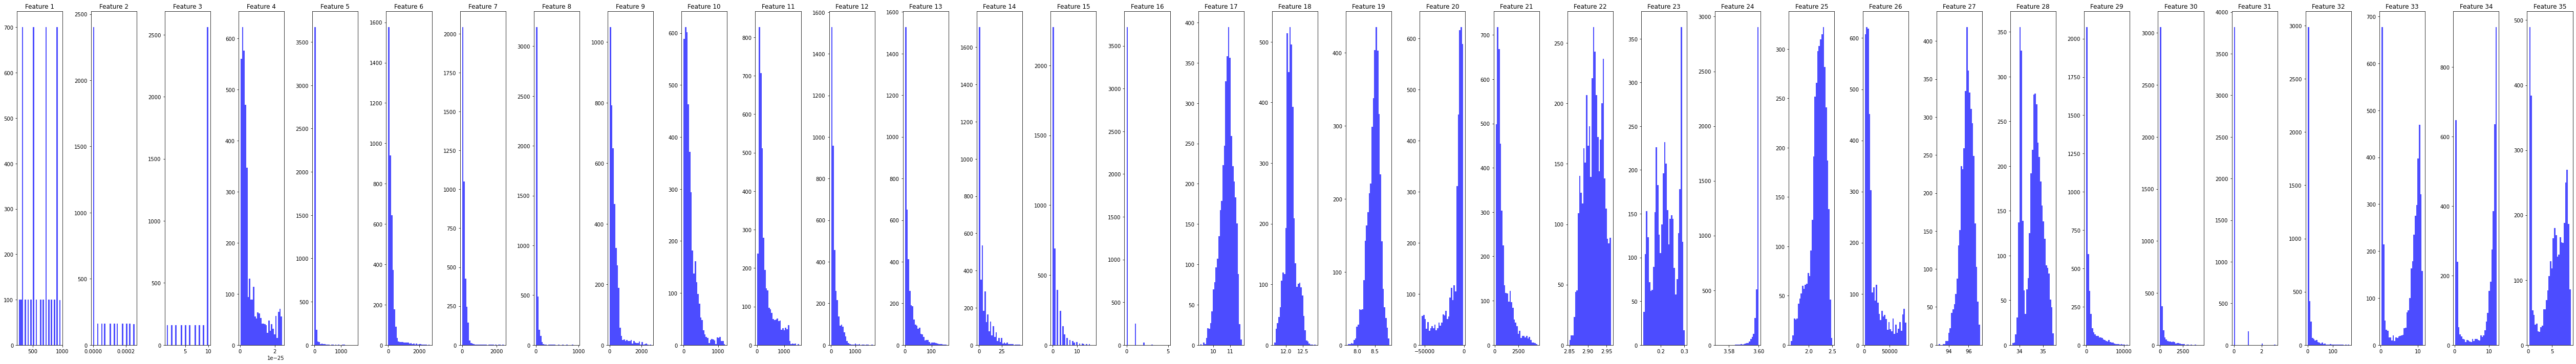

In [6]:
data = features_orig
fig, axs = plt.subplots(nrows=1, ncols=35, figsize=(70, 10))
for i in range(35):
    axs[i].hist(data[:, i], bins=30, color='blue', alpha=0.7)
    axs[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


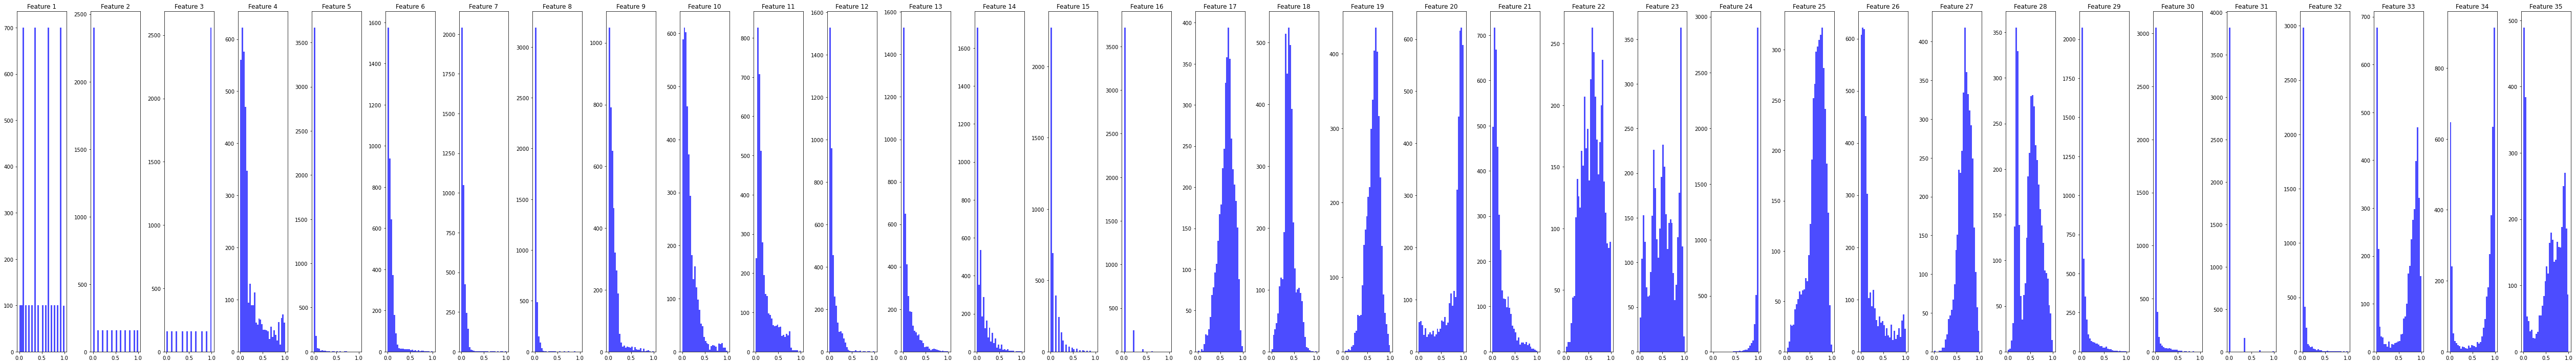

In [7]:
data = features_norm
fig, axs = plt.subplots(nrows=1, ncols=35, figsize=(70, 10))
for i in range(35):
    axs[i].hist(data[:, i], bins=30, color='blue', alpha=0.7)
    axs[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

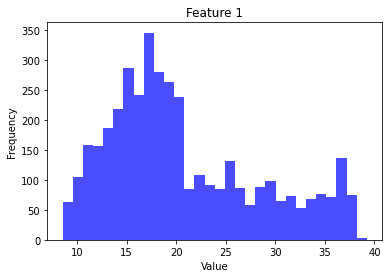

In [8]:
data = labels
plt.hist(data[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Feature 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Split the dataset into train , test and validation splits

In [9]:
# Split data into train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features_norm, labels, test_size=0.2, random_state=42)

print(f"features train shape: {features_train.shape}")
print(f"features test shape: {features_test.shape}") # tmp 
print(f"labels train shape: {labels_train.shape}")
print(f"labes test shape: {labels_test.shape}") # tmp

print(f"features train type: {type(features_train)}")
print(f"features test type: {type(features_test)}")
print(f"labels train type: {type(labels_train)}")
print(f"labes test type: {type(labels_test)}")

#test set again split into actual test and validation sets
features_validation, features_test, labels_validation, labels_test = train_test_split(features_test, labels_test, test_size=0.5, random_state=42)

print(f"features validation shape: {features_validation.shape}")
print(f"features test shape: {features_test.shape}")
print(f"labels validation shape: {labels_validation.shape}")
print(f"labes test shape: {labels_test.shape}")

print(f"features validation type: {type(features_validation)}")
print(f"features test type: {type(features_test)}")
print(f"labels validation type: {type(labels_validation)}")
print(f"labes test type: {type(labels_test)}")

features train shape: (3199, 35)
features test shape: (800, 35)
labels train shape: (3199, 1)
labes test shape: (800, 1)
features train type: <class 'numpy.ndarray'>
features test type: <class 'numpy.ndarray'>
labels train type: <class 'numpy.ndarray'>
labes test type: <class 'numpy.ndarray'>
features validation shape: (400, 35)
features test shape: (400, 35)
labels validation shape: (400, 1)
labes test shape: (400, 1)
features validation type: <class 'numpy.ndarray'>
features test type: <class 'numpy.ndarray'>
labels validation type: <class 'numpy.ndarray'>
labes test type: <class 'numpy.ndarray'>


In [10]:
def calc_MAPE_Percentage(actual_list , predicted_list):
#     assert len(predicted_list.shape) ==2
#     assert isinstance(predicted_list, list)
    assert len(actual_list.shape) == 2
    tmp=0
    num_samples = actual_list.shape[0]
        
    if len(predicted_list.shape) == 2:
#         print('con1')
        for i in range(num_samples):
            tmp += (np.abs(actual_list[i,0] - predicted_list[i,0]))/(np.abs(actual_list[i,0]))
    elif len(predicted_list.shape) == 1:
#         print('con2')
        for i in range(num_samples):
            tmp += (np.abs(actual_list[i,0] - predicted_list[i]))/(np.abs(actual_list[i,0])) 
    else:
        raise AssertionError
    MAPD = tmp/num_samples
    MAPD_perc = MAPD*100
    return MAPD_perc
    

## Model Training

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


name ='RF'
# X_train, X_test, y_train, y_test = features_train,features_validation,labels_train,labels_validation

params_grid = {
    'n_estimators': [64, 128, 256, 512, 1024, 2048, 4096, 8192],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 50],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}


# params_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [None,2]
# }

rf = RandomForestRegressor(random_state = 42)

rf_grid = GridSearchCV(estimator=rf, param_grid=params_grid, cv=5, verbose=2, n_jobs=-1)


predictions_list = {'train':None,'test':None,'val':None}

training_start = time.time()
rf_grid.fit(features_train, labels_train)
training_end = time.time()

print("Best parameters found: ", rf_grid.best_params_)
print("Best grid search score: ", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
print('E', rf_best)

val_start = time.time()
y_pred_validation = rf_best.predict(features_validation)
val_end = time.time()
predictions_list['val'] = y_pred_validation

y_pred_train = rf_best.predict(features_train)
predictions_list['train'] = y_pred_train

testing_start = time.time()
y_pred_test = rf_best.predict(features_test)
# y_pred = rf_best.predict(features_test)
testing_end = time.time()
predictions_list['test'] = y_pred_test

#metrics for train, test and validation
val_rmse = mean_squared_error(labels_validation, predictions_list['val'], squared = False)
val_mse = mean_squared_error(labels_validation, predictions_list['val'], squared = True)
val_mae = mean_absolute_error(labels_validation, predictions_list['val'])
val_mapd = calc_MAPE_Percentage(labels_validation,predictions_list['val'])
val_r2 = r2_score(labels_validation, predictions_list['val'])
print(f"Validation set with {name} - RMSE: {val_rmse:.10f}, MSE: {val_mse:.10f}, MAE: {val_mae:.10f} , MAPD:{val_mapd:.8f} , R^2: {val_r2:.10f}")

train_rmse = mean_squared_error(labels_train, predictions_list['train'], squared = False)
train_mse = mean_squared_error(labels_train, predictions_list['train'], squared = True)
train_mae = mean_absolute_error(labels_train, predictions_list['train'])
train_mapd = calc_MAPE_Percentage(labels_train,predictions_list['train'])
train_r2 = r2_score(labels_train, predictions_list['train'])
print(f"Train set with {name} - RMSE: {train_rmse:.10f}, MSE: {train_mse:.10f}, MAE: {train_mae:.10f},MAPD:{train_mapd:.8f} , R^2: {train_r2:.10f}")

test_rmse = mean_squared_error(labels_test, predictions_list['test'], squared = False)
test_mse = mean_squared_error(labels_test, predictions_list['test'], squared = True)
test_mae = mean_absolute_error(labels_test, predictions_list['test'])
test_mapd = calc_MAPE_Percentage(labels_test,predictions_list['test'])
test_r2 = r2_score(labels_test, predictions_list['test'])
print(f"Test set with {name} - RMSE: {test_rmse:.10f}, MSE: {test_mse:.10f}, MAE: {test_mae:.10f}, MAPD:{test_mapd:.8f} , R^2: {test_r2:.10f}")

print("Time taken for training: {:.10f} seconds".format(training_end - training_start)) 
print("Time taken for testing: {:.10f} seconds".format(testing_end - testing_start))
print("Time taken for validation: {:.10f} seconds".format(val_end - val_start))


Fitting 5 folds for each of 2560 candidates, totalling 12800 fits


C:\Users\sanka\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\sanka\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters found:  {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1024}
Best grid search score:  0.9990851441962658
E RandomForestRegressor(max_depth=15, n_estimators=1024, random_state=42)
Validation set with RF - RMSE: 0.2500578162, MSE: 0.0625289115, MAE: 0.1295100793 , MAPD:0.67598344 , R^2: 0.9988748521
Train set with RF - RMSE: 0.0797938377, MSE: 0.0063670565, MAE: 0.0458577023,MAPD:0.22437124 , R^2: 0.9998897852
Test set with RF - RMSE: 0.2787693261, MSE: 0.0777123372, MAE: 0.1416170348, MAPD:0.64400372 , R^2: 0.9987173900
Time taken for training: 37864.7085545063 seconds
Time taken for testing: 0.1289999485 seconds
Time taken for validation: 0.1289999485 seconds


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


name ='RF'
# X_train, X_test, y_train, y_test = features_train,features_validation,labels_train,labels_validation

params_grid = {
    'n_estimators': [1024],
    'max_depth': [10, 15],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}


# params_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [None,2]
# }

rf = RandomForestRegressor(random_state = 42)

rf_grid = GridSearchCV(estimator=rf, param_grid=params_grid, cv=5, verbose=2, n_jobs=-1)


predictions_list = {'train':None,'test':None,'val':None}

training_start = time.time()
rf_grid.fit(features_train, labels_train)
training_end = time.time()

print("Best parameters found: ", rf_grid.best_params_)
print("Best grid search score: ", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
print('E', rf_best)

val_start = time.time()
y_pred_validation = rf_best.predict(features_validation)
val_end = time.time()
predictions_list['val'] = y_pred_validation

y_pred_train = rf_best.predict(features_train)
predictions_list['train'] = y_pred_train

testing_start = time.time()
y_pred_test = rf_best.predict(features_test)
# y_pred = rf_best.predict(features_test)
testing_end = time.time()
predictions_list['test'] = y_pred_test

#metrics for train, test and validation
val_rmse = mean_squared_error(labels_validation, predictions_list['val'], squared = False)
val_mse = mean_squared_error(labels_validation, predictions_list['val'], squared = True)
val_mae = mean_absolute_error(labels_validation, predictions_list['val'])
val_mapd = calc_MAPE_Percentage(labels_validation,predictions_list['val'])
val_r2 = r2_score(labels_validation, predictions_list['val'])
print(f"Validation set with {name} - RMSE: {val_rmse:.10f}, MSE: {val_mse:.10f}, MAE: {val_mae:.10f} , MAPD:{val_mapd:.8f} , R^2: {val_r2:.10f}")

train_rmse = mean_squared_error(labels_train, predictions_list['train'], squared = False)
train_mse = mean_squared_error(labels_train, predictions_list['train'], squared = True)
train_mae = mean_absolute_error(labels_train, predictions_list['train'])
train_mapd = calc_MAPE_Percentage(labels_train,predictions_list['train'])
train_r2 = r2_score(labels_train, predictions_list['train'])
print(f"Train set with {name} - RMSE: {train_rmse:.10f}, MSE: {train_mse:.10f}, MAE: {train_mae:.10f},MAPD:{train_mapd:.8f} , R^2: {train_r2:.10f}")

test_rmse = mean_squared_error(labels_test, predictions_list['test'], squared = False)
test_mse = mean_squared_error(labels_test, predictions_list['test'], squared = True)
test_mae = mean_absolute_error(labels_test, predictions_list['test'])
test_mapd = calc_MAPE_Percentage(labels_test,predictions_list['test'])
test_r2 = r2_score(labels_test, predictions_list['test'])
print(f"Test set with {name} - RMSE: {test_rmse:.10f}, MSE: {test_mse:.10f}, MAE: {test_mae:.10f}, MAPD:{test_mapd:.8f} , R^2: {test_r2:.10f}")

print("Time taken for training: {:.10f} seconds".format(training_end - training_start)) 
print("Time taken for testing: {:.10f} seconds".format(testing_end - testing_start))
print("Time taken for validation: {:.10f} seconds".format(val_end - val_start))


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\sanka\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters found:  {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1024}
Best grid search score:  0.9990851441962658
E RandomForestRegressor(max_depth=15, n_estimators=1024, random_state=42)
Validation set with RF - RMSE: 0.2500578162, MSE: 0.0625289115, MAE: 0.1295100793 , MAPD:0.67598344 , R^2: 0.9988748521
Train set with RF - RMSE: 0.0797938377, MSE: 0.0063670565, MAE: 0.0458577023,MAPD:0.22437124 , R^2: 0.9998897852
Test set with RF - RMSE: 0.2787693261, MSE: 0.0777123372, MAE: 0.1416170348, MAPD:0.64400372 , R^2: 0.9987173900
Time taken for training: 63.7578084469 seconds
Time taken for testing: 0.1270198822 seconds
Time taken for validation: 0.1270067692 seconds


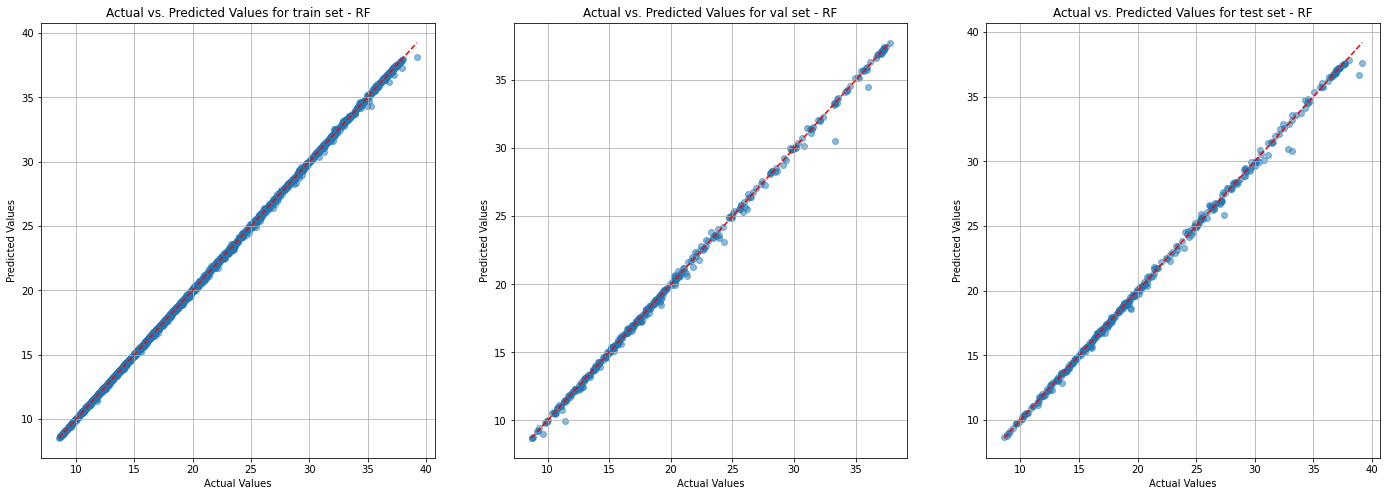

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
set_d = ['train', 'val','test']
labels_set = [labels_train.squeeze(), labels_validation.squeeze(), labels_test.squeeze()]

for i in range(3):
    axs[i].scatter(labels_set[i], predictions_list[set_d[i]], alpha=0.5)
    axs[i].set_title(f"Actual vs. Predicted Values for {set_d[i]} set - RF")
    axs[i].set_xlabel("Actual Values")
    axs[i].set_ylabel("Predicted Values")

    min_val = min(np.min(labels_set[i]), np.min(predictions_list[set_d[i]]))
    max_val = max(np.max(labels_set[i]), np.max(predictions_list[set_d[i]]))
    axs[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    axs[i].grid(True)
plt.show()

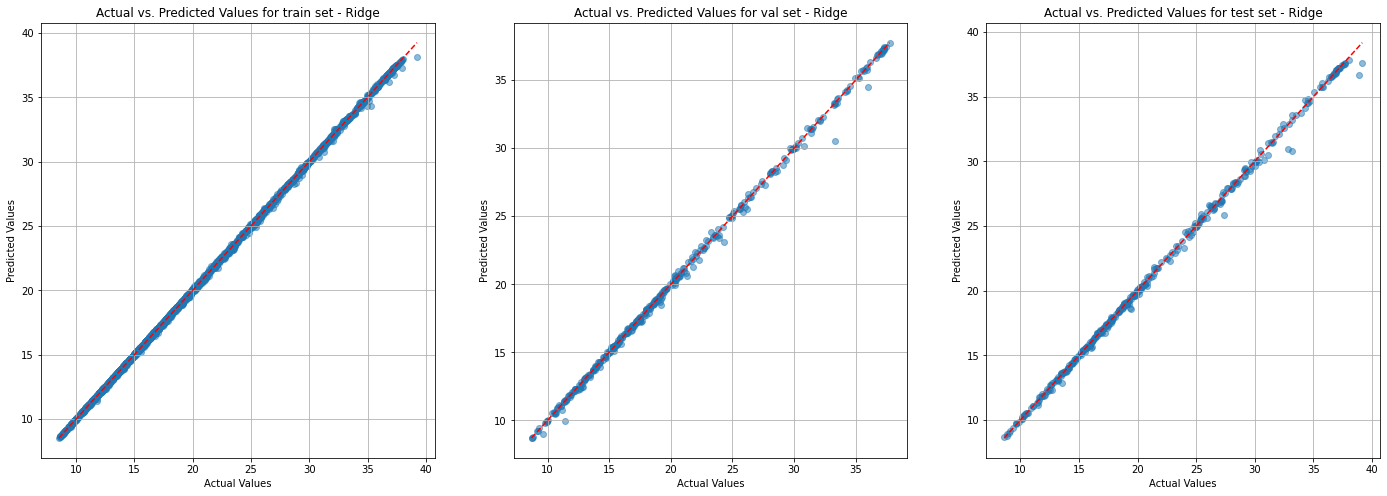

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
set_d = ['train', 'val','test']
labels_set = [labels_train.squeeze(), labels_validation.squeeze(), labels_test.squeeze()]

for i in range(3):
    axs[i].scatter(labels_set[i], predictions_list[set_d[i]], alpha=0.5)
    axs[i].set_title(f"Actual vs. Predicted Values for {set_d[i]} set - Ridge")
    axs[i].set_xlabel("Actual Values")
    axs[i].set_ylabel("Predicted Values")

    min_val = min(np.min(labels_set[i]), np.min(predictions_list[set_d[i]]))
    max_val = max(np.max(labels_set[i]), np.max(predictions_list[set_d[i]]))
    axs[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    axs[i].grid(True)
plt.show()

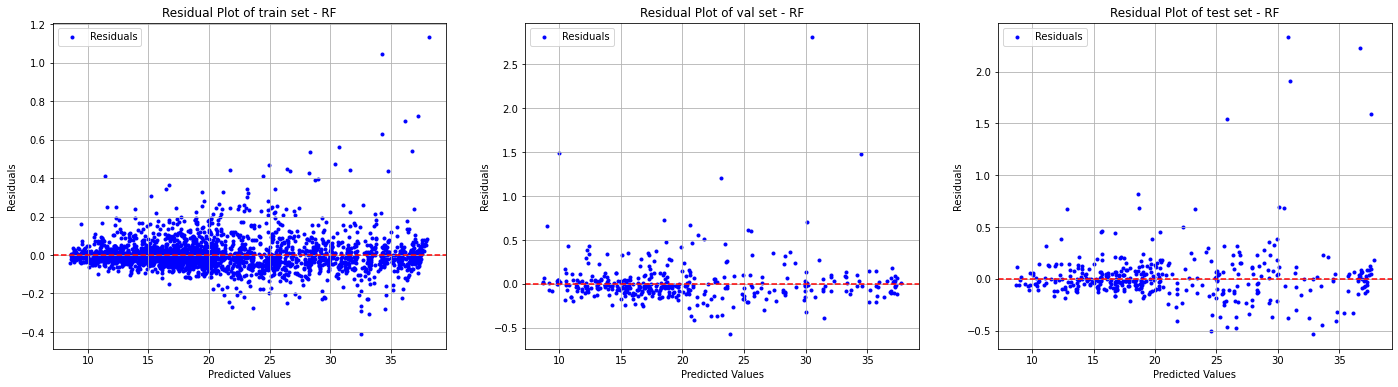

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns
residuals_set =  {'train':None,'test':None,'val':None}

for i in range(3):

    residuals = labels_set[i] - predictions_list[set_d[i]].squeeze()
    residuals_set[set_d[i]] = residuals
    
#     plt.figure(figsize=(8, 6))
    axs[i].scatter(predictions_list[set_d[i]], residuals, color='blue', marker='.', label='Residuals')
    axs[i].axhline(y=0, color='red', linestyle='--')
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Residuals')
    axs[i].set_title(f'Residual Plot of {set_d[i]} set - RF')
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
plt.show()

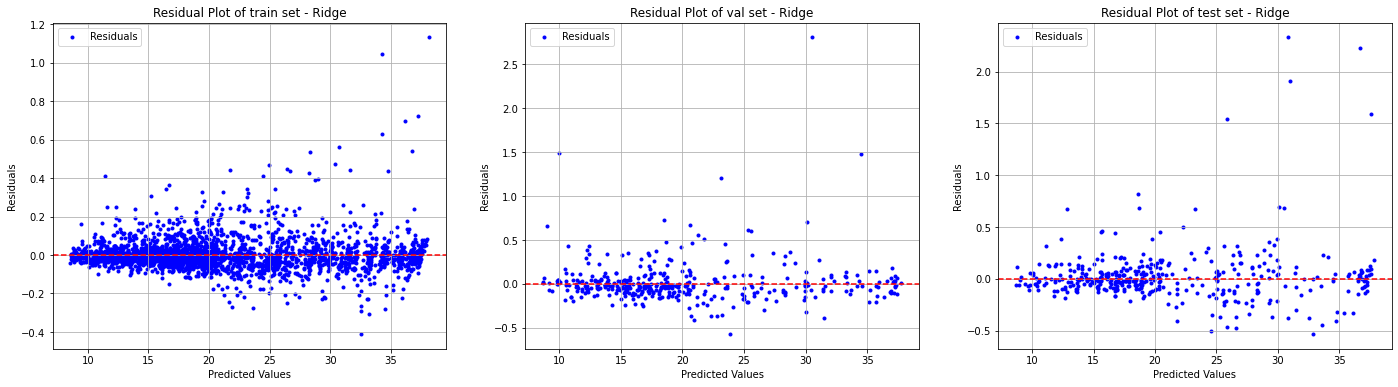

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns
residuals_set =  {'train':None,'test':None,'val':None}

for i in range(3):

    residuals = labels_set[i] - predictions_list[set_d[i]].squeeze()
    residuals_set[set_d[i]] = residuals
    
#     plt.figure(figsize=(8, 6))
    axs[i].scatter(predictions_list[set_d[i]], residuals, color='blue', marker='.', label='Residuals')
    axs[i].axhline(y=0, color='red', linestyle='--')
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Residuals')
    axs[i].set_title(f'Residual Plot of {set_d[i]} set - Ridge')
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
plt.show()

3199
400
400


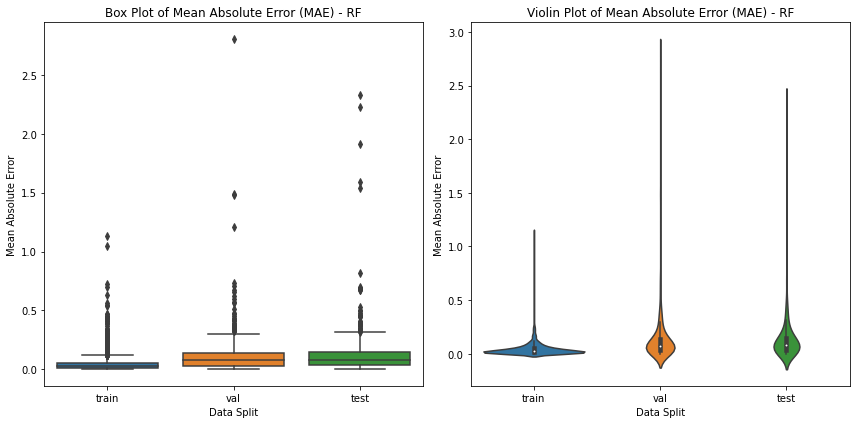

In [15]:
#train, test, val
df_list =[]
for i in range(3):
    num_samples = residuals_set[set_d[i]].shape[0]
    print(num_samples)
    mae_values = [abs(residuals_set[set_d[i]][j]) for j in range(num_samples)]
    df_list.append(pd.DataFrame(mae_values, columns=['MAE']))
    df_list[i]['Data Split'] = set_d[i]

combined_mae_df = pd.concat([df_list[0], df_list[1], df_list[2]])
    
plt.figure(figsize=(12, 6))

# Box plot
plt.subplot(1, 2, 1) 
sns.boxplot(x='Data Split', y='MAE', data=combined_mae_df)
# sns.boxplot(data=mae_df, y='MAE')
plt.title('Box Plot of Mean Absolute Error (MAE) - RF')
plt.xlabel('Data Split')
plt.ylabel('Mean Absolute Error')

# Violin plot
plt.subplot(1, 2, 2)  
# sns.violinplot(data=mae_df, y='MAE')
sns.violinplot(x='Data Split', y='MAE', data=combined_mae_df)
plt.title('Violin Plot of Mean Absolute Error (MAE) - RF')
plt.xlabel('Data Split')
plt.ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()

3199
400
400


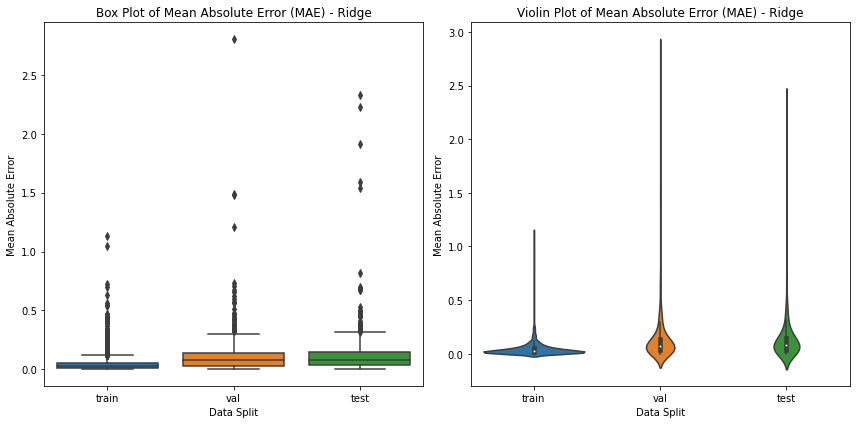

In [23]:
#train, test, val
df_list =[]
for i in range(3):
    num_samples = residuals_set[set_d[i]].shape[0]
    print(num_samples)
    mae_values = [abs(residuals_set[set_d[i]][j]) for j in range(num_samples)]
    df_list.append(pd.DataFrame(mae_values, columns=['MAE']))
    df_list[i]['Data Split'] = set_d[i]

combined_mae_df = pd.concat([df_list[0], df_list[1], df_list[2]])
    
plt.figure(figsize=(12, 6))

# Box plot
plt.subplot(1, 2, 1) 
sns.boxplot(x='Data Split', y='MAE', data=combined_mae_df)
# sns.boxplot(data=mae_df, y='MAE')
plt.title('Box Plot of Mean Absolute Error (MAE) - Ridge')
plt.xlabel('Data Split')
plt.ylabel('Mean Absolute Error')

# Violin plot
plt.subplot(1, 2, 2)  
# sns.violinplot(data=mae_df, y='MAE')
sns.violinplot(x='Data Split', y='MAE', data=combined_mae_df)
plt.title('Violin Plot of Mean Absolute Error (MAE) - Ridge')
plt.xlabel('Data Split')
plt.ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()